In [1]:
%matplotlib inline
from fancy_plot import *
import sys
import os
sys.path.append('/home/b/b309233/software/VPRM_preprocessor/')
import yaml 
from datetime import date
from lib.sat_manager import VIIRS, sentinel2, modis, earthdata,\
                        copernicus_land_cover_map, satellite_data_manager
from VPRM import vprm 

import glob
import time
import yaml
# with open("logins.yaml", "r") as stream:
#     try:
#         logins = yaml.safe_load(stream)
#     except yaml.YAMLError as exc:
#         print(exc)
import numpy as np
import xarray as xr
import rioxarray as rxr
from pyproj import Transformer
import xesmf as xe
import copy
import rasterio
import pandas as pd
import pickle
from rioxarray.merge import merge_arrays
import rioxarray as rxr
import simplekml
from functions import lat_lon_to_modis
import geopandas as gpd
from lib.functions import icos
from dateutil import parser


ModuleNotFoundError: No module named 'fancy_plot'

In [3]:
site_info = pd.read_pickle('/home/b/b309233/software/CO2KI/VPRM/fluxnet_sites.pkl')


In [4]:
#vprm_inst.calc_min_max_evi_lswi()
site_info = pd.read_pickle('/home/b/b309233/software/CO2KI/VPRM/fluxnet_sites.pkl')

site_list = {'grassland': ['AT-Neu', 'CH-Cha', 'CH-Fru', 'CZ-BK2', 'DE-Gri', 'DE-RuR', 'IT-MBo', 'IT-Tor'],
             'mixed_forests': ['BE-Bra', 'BE-Vie', 'CH-Lae'],
             'cropland': ['BE-Lon', 'CH-Oe2', 'DE-Geb', 'DE-Kli', 'DE-RuS', 'FR-Gri', 'IT-BCi', 'IT-CA2'],
             'evergeen': ['CH-Dav', 'CZ-BK1', 'DE-Lkb', 'DE-Obe', 'DE-Tha', 'FI-Hyy', 'FI-Let', 'FI-Sod',
                          'IT-Lav', 'IT-Ren', 'IT-SRo', 'NL-Loo', 'RU-Fyo'],
             'wetland': ['CZ-wet', 'DE-Akm', 'DE-SfN', 'DE-Spw', 'FR-Pue', 'IT-Cp2'],
             'deciduous': ['DE-Hai', 'DE-Lnf', 'DK-Sor', 'FR-Fon', 'IT-CA1', 'IT-CA3', 'IT-Col', 'IT-Ro2'],
             'shrubland': ['ES-Amo', 'ES-LJu', 'IT-Noe']}

all_sites = np.concatenate([site_list[i] for i in site_list.keys()])


In [41]:
t = icos_inst.get_data()

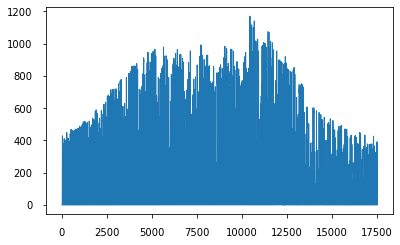

In [46]:
fig, ax = newfig(0.9)
ax.plot(range(len(t['SW_IN_F'])), t['SW_IN_F'])
fig.show()

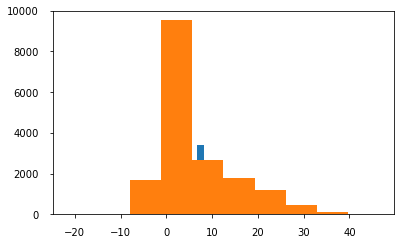

In [39]:
fig, ax = newfig(0.9)
ax.hist(icos_inst.get_data()['GPP_DT_VUT_REF'])
ax.hist(icos_inst.get_data()['GPP_NT_VUT_REF'])

fig.show()

2020    17568
2019    17520
2021    17520
2022    17519
2018        1
Name: count, dtype: int64

In [54]:
new_sites = []
tmin = parser.parse('{}0101'.format(2022))
tmax = parser.parse('{}0101'.format(2023))
for c, t in enumerate(glob.glob('/work/bd1231/tglauch/icos/*/*_VARINFO_FLUXNET_HH_L2.csv')):
    # if c>0:
    #     continue
    print(t)
    site = t.split('ICOSETC_')[1].split('_')[0]
    # if site != 'IT-Niv':
    #     continue
    icos_inst = icos(data_path=t.replace('_VARINFO', ''))
    icos_inst.add_tower_data()
    print(pd.Series([t.year for t in icos_inst.get_data()['datetime_utc']]).value_counts())
    new_sites.append(icos_inst)
    print(site, icos_inst.get_land_type())

/work/bd1231/tglauch/icos/ICOSETC_FR-Mej_ARCHIVE_L2/ICOSETC_FR-Mej_VARINFO_FLUXNET_HH_L2.csv
2020    17568
2019    17520
2021    17520
2022    17519
2018        1
Name: count, dtype: int64
FR-Mej GRA
/work/bd1231/tglauch/icos/ICOSETC_FI-Hyy_ARCHIVE_L2/ICOSETC_FI-Hyy_VARINFO_FLUXNET_HH_L2.csv
2020    17568
2018    17520
2019    17520
2021    17520
2022    17517
2017        3
Name: count, dtype: int64
FI-Hyy ENF
/work/bd1231/tglauch/icos/ICOSETC_DE-Msr_ARCHIVE_L2/ICOSETC_DE-Msr_VARINFO_FLUXNET_HH_L2.csv
2020    17568
2021    17520
2022    17519
2019        1
Name: count, dtype: int64
DE-Msr ENF
/work/bd1231/tglauch/icos/ICOSETC_CZ-BK1_ARCHIVE_L2/ICOSETC_CZ-BK1_VARINFO_FLUXNET_HH_L2.csv
2022    17519
2021        1
Name: count, dtype: int64
CZ-BK1 ENF
/work/bd1231/tglauch/icos/ICOSETC_FR-EM2_ARCHIVE_L2/ICOSETC_FR-EM2_VARINFO_FLUXNET_HH_L2.csv
2020    17568
2017    17520
2018    17520
2019    17520
2021    17520
2022    17519
2016        1
Name: count, dtype: int64
FR-EM2 CRO
/work/bd1231/t

In [6]:
with open('../configs/config_draft.yaml', "r") as stream:
    try:
        cfg  = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


In [33]:
sat_data_bpath = '/work/bd1231/tglauch/modis_images_new/2012'
for hv in cfg['hvs']:

    h= hv[0]
    v= hv[1]
    print(h, v)
    handler = modis(sat_image_path=glob.glob(os.path.join(sat_data_bpath, '*h{:02d}v{:02d}*.h*'.format(h, v)))[0])
    handler.load()
    handler.sat_img = handler.sat_img.reindex(x=sorted(list(handler.sat_img.x)))
    handler.sat_img = handler.sat_img.reindex(y=sorted(list(handler.sat_img.y)))

    for s in new_sites:
        lon = s.get_lonlat()[0]
        lat= s.get_lonlat()[1]
        thv = lat_lon_to_modis(lat, lon)
        if not ((thv[0] == h) & (thv[1]==(v))):
            continue
        print(s.get_site_name(), lon, lat)
        t = Transformer.from_crs('+proj=longlat +datum=WGS84',
                                  handler.sat_img.rio.crs)
        x_a, y_a = t.transform(lon, lat)
        ind_x = np.where((handler.sat_img.coords['x'].values - x_a) > 0)[0][0]
        ind_y = np.where((handler.sat_img.coords['y'].values - y_a) > 0)[0][0]
        
        print(ind_x, ind_y)
        corners = [(handler.sat_img.coords['x'].values[ind_x-1], handler.sat_img.coords['y'].values[ind_y-1]),
                  (handler.sat_img.coords['x'].values[ind_x], handler.sat_img.coords['y'].values[ind_y-1]),
                  (handler.sat_img.coords['x'].values[ind_x], handler.sat_img.coords['y'].values[ind_y]),
                  (handler.sat_img.coords['x'].values[ind_x-1], handler.sat_img.coords['y'].values[ind_y]),
                  (handler.sat_img.coords['x'].values[ind_x-1], handler.sat_img.coords['y'].values[ind_y-1])]
        t = Transformer.from_crs(handler.sat_img.rio.crs,
                                '+proj=longlat +datum=WGS84')    
        corners = [t.transform(i[0], i[1]) for i in corners]
        kml = simplekml.Kml()
        kml.newpoint(coords=[(lon, lat)])  # lon, lat, optional height
        linestring = kml.newlinestring(name="A Line")
        linestring.coords = corners
        kml.save("/home/b/b309233/kmls_new/{}.kml".format(s.get_site_name()))

17 2
17 3
UK-AMo -3.2436918 55.792546
1962 1390
17 4
FR-Mej -1.79635 48.1184
2112 1948
FR-Bil -0.956092 44.493653
2236 1078
17 5
18 2
SE-Sto 19.04520892 68.35594288
1686 2005
SE-Nor 17.47950278 60.08649722
2092 21
FI-Ken 24.24301028 67.98721472
2181 1917
SE-Deg 19.556539 64.182029
2044 1004
SE-Svb 19.7745 64.25611
2061 1021
18 3
DK-Gds 9.3341 56.0737
1250 1458
DE-RuW 6.33096247542595 50.5049268531233
966 121
DK-Skj 8.40481 55.91273
1131 1419
BE-Maa 5.631851 50.979868
851 235
DE-HoH 11.22235 52.08656
1655 501
SE-Htm 13.41897 56.09763
1796 1463
BE-Lcr 3.85043 51.11218
580 267
DK-Vng 9.16070962 56.0374765
1228 1449
18 4
DE-Msr 11.456168 47.809181
1847 1874
FR-EM2 3.02065 49.8721083
467 2369
FR-LGt 2.284102 47.322917
372 1758
IT-Lsn 12.750297 45.740481
2136 1378
IT-SR2 10.29091 43.732022
1785 896
IT-Niv 7.13943 45.49091
1201 1318
DE-Har 7.5981 47.933
1222 1904
IT-BFt 10.741966 45.197755
1817 1247
FR-Hes 7.06465 48.6741
1120 2082
FR-Aur 1.106103 43.549649
192 852
FR-Tou 1.37474 43.572855
23